In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import io
import requests
import cv2 

import numpy as np
import matplotlib.pyplot as plt

from io import BytesIO

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from pathlib import Path
from fastai.metrics import error_rate
from fastai.vision.interpret import SegmentationInterpretation
import random
import torch
import torch.nn as nn
import PIL 
from PIL import Image
import cv2 
import numpy as np 
import requests


In [3]:
def pix_per_class(img):
    """returns unique dictionary with class numbers for keys and number of pixels per class as values"""
    unique, counts = np.unique(img, return_counts=True)
    unique = [int(i) for i in unique]
    act_classes = dict(zip(unique, counts))
    
    return act_classes

def most_pixels_nozero(img):
    """Returns class with the most pixels
    Takes in the image, makes a dictionary with keys for class number and value for number of pixels in that class
    Determines which class has the most pixels and returns that class
    Also deletes pixels labeled zero
    """
    unique, counts = np.unique(img, return_counts=True)
    act_classes = dict(zip(unique, counts))
    if 0 in act_classes:
        del act_classes[0]
    v=list(act_classes.values())
    k=list(act_classes.keys())
    return k[v.index(max(v))]
    
def most_pixels(img):
    """Returns class with the most pixels
    Takes in the image, makes a dictionary with keys for class number and value for number of pixels in that class
    Determines which class has the most pixels and returns that class
    """
    unique, counts = np.unique(img, return_counts=True)
    act_classes = dict(zip(unique, counts))
    v=list(act_classes.values())
    k=list(act_classes.keys())
    return k[v.index(max(v))]

def closest(lst, K): 
    """given a list of ints and input int, returns int from list that is closest to input int"""
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))] 

def center_finder(model_out_array):
    class_ids = list(range(20))
    new = np.zeros(model_out_array.shape[1:], dtype=np.int64)
    new[(model_out_array[0, :, :] > 2) & (model_out_array[0, :, :] < 19)] = 1
    contour, hier = cv2.findContours(
        new, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    external = np.zeros(new.shape)
    lst = []
    middle = np.array([128, 128])

    contour_indices = []

    for i in range(len(contour)):
        if hier[0][i][3] == -1:
            area = cv2.contourArea(contour[i])
            if area > 200:
                coords = contour[i].reshape((-1, 2))
                lst.append(coords.mean(axis=0))
                contour_indices.append(i)

    lst = np.array(lst)
    closest_blob = contour_indices[np.argmin(np.sum(np.square(lst - middle), axis=1))]
    right_contours = contour[closest_blob]
    area_middle = cv2.contourArea(contour[closest_blob])
    cv2.drawContours(external, contour, closest_blob, 255, -1)
    seg = np.zeros(model_out_array.shape[1:], dtype=np.int32)
    seg[external == 255] = model_out_array[0][external == 255]
    return seg, right_contours, area_middle

"""
for each contour in the singled out image
1. create new blank image
2. apply contours from that blob onto blank image with pixel values from singled_out image
3. Find most common class of pixels for that class (excluding 0)
4. In another new blank image, called final_product, draw that those contours with the most common pixel
pulled from previous steps

"""
def change_to_most_pix(singled_out, area_middle ):
    sing_contour, sing_hier = cv2.findContours(singled_out,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

    new = np.zeros((256, 256) , dtype=np.int64)
    sing_external = np.zeros(new.shape)
    final_product = np.zeros(new.shape)

    for i in range(len(sing_contour)):
        if sing_hier[0][i][3] == -1:
            sing_area = cv2.contourArea(sing_contour[i])
            if sing_area > 60 and sing_area < area_middle:
                sing_external = np.zeros(new.shape)
                single_seg = np.zeros_like((singled_out) , dtype=np.int32)

                cv2.drawContours(sing_external,sing_contour,i,255,-1)
                single_seg[sing_external == 255] = singled_out[sing_external == 255]

                max_pix_this = int(most_pixels_nozero(single_seg))
                cv2.drawContours(final_product,sing_contour,i,max_pix_this,-1)
                
    return final_product

"""
Removes bad north facing roof directions and turns pixels into kilowatts
in: dict. containing pixels per class
out: dict. containing kwh per class only for best roof faces
Turns pixels to raw DC watts by doing
pixels -> sqft -> panels - > watts DC
only arbitrary for now
"""


def remove_and_reduce(final_dict):
    kw_dict = {}
    #changed7
    arbitrary_num = 350
    max_dc_kw = 0
    # come back and change arbitrary_num once I get what it is
    for i in final_dict:
        if i > 5 and i < 17:
            kw_dict[i] = round(final_dict[i]/arbitrary_num, 2)
            max_dc_kw += kw_dict[i]
    return kw_dict, max_dc_kw



In [4]:
def closest(lst, K): 
    """given a list of ints and input int, returns int from list that is closest to input int"""
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))] 

def center_finder(model_out_array, sat_array):
    class_ids = list(range(2))
    
    #new = np.zeros(model_out_array.shape[1:], dtype=np.int64)
    #new[(model_out_array[0, :, :] > 2) & (model_out_array[0, :, :] < 19)] = 1
    
    contour, hier = cv2.findContours(model_out_array, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    external = np.zeros(model_out_array.shape)
    lst = []
    middle = np.array([128, 128])

    contour_indices = []

    for i in range(len(contour)):
        if hier[0][i][3] == -1:
            area = cv2.contourArea(contour[i])
            if area > 200:
                coords = contour[i].reshape((-1, 2))
                lst.append(coords.mean(axis=0))
                contour_indices.append(i)

    lst = np.array(lst)
    closest_blob = contour_indices[np.argmin(np.sum(np.square(lst - middle), axis=1))]
    right_contours = contour[closest_blob]
    area_middle = cv2.contourArea(contour[closest_blob])
    cv2.drawContours(external, contour, closest_blob, 255, -1)
    seg = np.zeros(model_out_array.shape, dtype=np.int32)
    seg[external == 255] = model_out_array[external == 255]
    return seg, right_contours, area_middle, model_out_array

In [5]:
def pix_per_class(img):
    """returns unique dictionary with class numbers for keys and number of pixels per class as values"""
    unique, counts = np.unique(img, return_counts=True)
    unique = [int(i) for i in unique]
    act_classes = dict(zip(unique, counts))
    
    return act_classes

In [72]:
def image_loader(loader, image):
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

model = torch.jit.load('fa_jit2.pt',map_location=torch.device('cpu'))


In [87]:
map_payload = {
        'center': '2413 Par Rd, Sebring, FL 33872' ,
        'zoom':'20',
        'size':'512x512',
        'format':'jpg',
        'maptype':'satellite',
        'key': key

    }
r = requests.get("https://maps.googleapis.com/maps/api/staticmap?", params=map_payload)
image_bytes = r.content
image = Image.open(io.BytesIO(image_bytes))

In [88]:
npimg = np.array(image)

In [89]:
npimg.shape

(512, 512, 3)

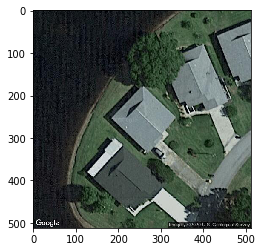

In [90]:
plt.imshow(npimg)

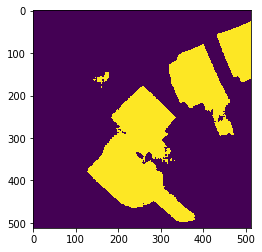

In [100]:
plt.imshow(arrgm)

In [91]:
img = image_loader(data_transforms, image)

/home/kyle/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [92]:
out = model(img)

In [93]:
type(out)

torch.Tensor

In [94]:
outnp = np.array(out.detach().numpy())

In [95]:
out[0,0].shape

torch.Size([512, 512])

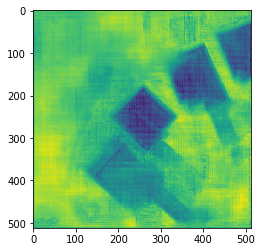

In [96]:
plt.imshow(outnp[0,0])

In [43]:
def pix_per_class(img):
    """returns unique dictionary with class numbers for keys and number of pixels per class as values"""
    unique, counts = np.unique(img, return_counts=True)
    unique = [int(i) for i in unique]
    act_classes = dict(zip(unique, counts))
    
    return act_classes

In [44]:
pix_per_class(arrgm)


{0: 76768, 1: 185376}